In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib inline

In [2]:
def FDTD(z_axis, t_axis, Hs, Es, mHx, mEy): 
    """
    Args:
        z_axis: Numpy array of linearly spaced points on z axis
        t_axis: Numpy array of linearly spaced time values
        Hs:     Numpy array over time axis of Magnetic Field due to source 
        Es:     Numpy array over time axis of Electric Field due to source 
        mHx:    Numpy array over z_axis of update coefficient for magnetic field
        mEy:    Numpy array over z_axis of update coefficient for electric field 
    
    Returns:
        EOverTime: Numpy array of E field values over z-axis over time 
        HOverTime: Numpy array of E field values over z-axis over time 
        
        such that EOverTime[t][z] gives Electric field value at time t and position z (t and z are indexs for t_axis and z_axis respectively)
    
    Perfectly Absorbing Boundary conditions are applied to the axis, and hence values of electric and magnetic field are noted upto two previous steps (e1,e2,h1,h2)
    
    mHx, mEy are update coefficients that should have values equaling (in accordance to maxwell's equations):
        mHx = dt*c0/(mew*dz)
        mEy[i] = dt*c0/(ep*dz) 
    where mew is the permeability in the region and ep is the permittivity in the region, c0 is the speed of EM radiaition in free space 
    and dz and dt are the space and time steps respectively
    """
    Nz = z_axis.size
    steps = t_axis.size
    
    Hx, Ey = np.zeros([Nz]), np.zeros([Nz])
    HxOverTime = np.array([Hx])
    EyOverTime = np.array([Ey])
    
    h2 = h1 = e2 = e1 = 0
    
    for t in range(1,steps,1):
    
        Hx = HxOverTime[t-1]
        Ey = EyOverTime[t-1]
        
        h2 = h1
        h1 = Hx[0]
        
        Hx[:Nz-1] += mHx[:Nz-1]*(Ey[1:]-Ey[:Nz-1])
        Hx[Nz-1] += mHx[Nz-1]*(e2-Ey[Nz-1])
        
        HxOverTime[t-1][2] -= mHx[2]*Es[t]
        HxOverTime = np.append(HxOverTime, np.array([Hx]), axis=0)
        
        e2 = e1
        e1 = Ey[Nz-1]
        
        Ey[0] += mEy[0]*(Hx[0]- h2)
        Ey[1:] += mEy[1:]*(Hx[1:]-Hx[:Nz-1])   
        
        EyOverTime[t-1][3] -= mEy[3]*Hs[t]
        EyOverTime = np.append(EyOverTime, np.array([Ey]), axis=0)
    
    return HxOverTime, EyOverTime

In [3]:
#Setting constants and environment parameters

rel_permittivity = 1.4
abs_permittivity = 8.8541878*(10**(-12))
permittivity     = rel_permittivity * abs_permittivity

rel_permeability = 1.4
abs_permeability = 4*(np.pi)*(10**(-7))
permeability     = abs_permeability * rel_permeability

n = np.sqrt(rel_permittivity * rel_permeability) # refractive index

c0 = 299792458
cn = c0/n

In [4]:
#Grid Resolution
dz = 0.1

#Grid Size
Nz = 200
gridLen = Nz*dz
z_axis = np.linspace(0,gridLen, Nz)

m, e, n_grid = np.ones([Nz]), np.ones([Nz]), np.ones([Nz])
for i in range(int(Nz/2), Nz-4, 1):
    m[i] = 2.0
    e[i] = 2.0
    n_grid[i] = np.sqrt(m[i]*e[i])
    
#Time Step
dt = dz/(2*c0)    #dt is chosen to be dz/2*c0 so that the magnitude of c0*dt and dx have the same order of magnitude

#Time Period
steps = 1500
timePeriod = steps*dt
t_axis = np.linspace(0, timePeriod, steps)

#Update Coefficients for fdtd 
mHx, mEy = np.ones([Nz]), np.ones([Nz])
for i in range(0, Nz, 1):
    mHx[i] = dt*c0/(m[i]*dz)
    mEy[i] = dt*c0/(e[i]*dz) 

In [5]:
#Gaussian source (impulse)
def Esrc(t, t0, tau):
    return np.exp(-((t-t0)/tau)**2) 

def Hsrc(t, t0, tau, A):
    return A*np.exp(-((t-t0+3*dt/2)/tau)**2 )

#Source Parameters
tau = 20*dt
t0  = 6*tau

del_t = 2*dt/2                                  #Staggering between Electric and Magnetic Fields
A = -np.sqrt(rel_permittivity/rel_permeability) #Normalizing Magnetic Field so it has the same order of magnitude as electric field

#Generating Electric and Magnetic Field due to source over time
Es = Esrc(t_axis, t0, tau)
Hs = Hsrc(t_axis, t0, tau, A)

In [6]:
#Running simulation
HOverTime, EOverTime = FDTD(z_axis, t_axis, Hs, Es, mHx, mEy)

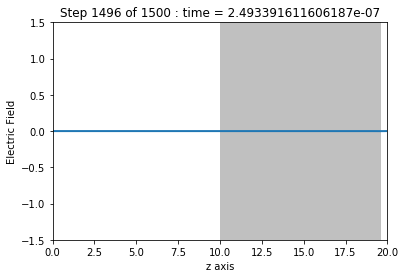

In [7]:
#Animation
fig = plt.figure(figsize=(6,4))
ax = plt.axes(xlim=(0, gridLen), ylim = (-1.5,1.5))

#The region with different refractive index is colored silver
for i in range(0, Nz, 1):
    if n_grid[i] == 1.0:
        plt.axvspan(i*dz, (i+1)*dz, facecolor='w')
    else:
        plt.axvspan(i*dz, (i+1)*dz, facecolor='silver')

ax.set_xlabel('z axis')
ax.set_ylabel('Electric Field')

line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

#Every 5 steps 
def animate(t):
    x = z_axis
    y = EOverTime[5*t]
    plt.title("Step " + str(5*t+1) + " of " + str(steps)+ " : time = " + str(5*t*dt))
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=int(steps/5), interval=2, blit=True)

anim.save("EOverZ.gif", writer='imagemagick')  